In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
"""

    credit :Zhejie Ding, https://github.com/zdplayground/emcee_fit_Pwnw
    
    
    Copy the code mcmc_fit_nonlinear_BAO from /Users/ding/Documents/playground/shear_ps/SVD_ps/mcmc_fit
    modify it to fit observed power spectrum Pwig with damped BAO.
    Modify the function cal_pk_model in the lnprob module for the fitting model:
    Pwig(k') = A*((Plin(k) - Psm(k))*exp(-k^2*Sigma^2/2) + Psm(k)) + B; --09/25/2017
"""

import sys
import os
import emcee
import time
import numpy as np
import argparse
import corner
import matplotlib.pyplot as plt


from scipy.optimize    import minimize
from scipy.interpolate import InterpolatedUnivariateSpline
from baoutils import match_params
from baoutils import lnprior_prebeutler as lnprior 
from baoutils import cal_pk_model_prebeutler as cal_pk_model

sys.path.append('/Users/mehdi/github/LSSutils')
from LSSutils.utils import D as growth_factor

camb is not installed!


In [3]:
def gelman_rubin_convergence(withinchainvar, meanchain, n, Nchains, ndim):
    """
    Gelman & Rubin convergence criterion, 
    referenced from Florian's code RSDfit_challenge_hex_steps_fc_hoppper.py

     Calculate Gelman & Rubin diagnostic
     1. Remove the first half of the current chains
     2. Calculate the within chain and between chain variances
     3. estimate your variance from the within chain and between chain variance
     4. Calculate the potential scale reduction parameter
     
     
     parameters
     ----------
     withinchainvar :
     meanchain : 
     n : 
     Nchains : 
     ndim : 
     
     returns
     -------
     scalereduction :
     
    """
    meanall = np.mean(meanchain, axis=0)
    W       = np.mean(withinchainvar, axis=0)
    B       = np.zeros(ndim, dtype=np.float)
    
    for jj in range(0, Nchains):
        
        B = B + n*(meanall - meanchain[jj])**2/(Nchains-1.)
        
    estvar = (1. - 1./n)*W + B/n
    scalereduction = np.sqrt(estvar/W)
    return scalereduction


def write_params(filename, params_mcmc, params_name, reduced_chi2):
    """
      write parameters fitted in files
      
      
      parameters
      ----------
      filename : str
      params_mcmc : list of float
      params_name : list of str
      reduced_chi2 : float
      
      
    """
    header_line = '# The fitted parameters {} (by row) with their upward'\
                + ' and downward one sigma error, and the reduced \chi^2.\n'\
                .format(params_name[:])

    with open(filename, 'w') as fwriter:
        
        fwriter.write(header_line)
        
        for i in range(len(params_name)):
            
            fwriter.write("#{0}: {1:.7f} {2:.7f} {3:.7f}\n"\
                   .format(params_name[i], params_mcmc[i][0],
                           params_mcmc[i][1], params_mcmc[i][2]))
            
        fwriter.write("#reduced_chi2: {0:.7f}".format(reduced_chi2))


        
def set_params(all_params, params_indices, all_names, all_temperature):
    """
     Define a function to set parameters which are free and which are fixed.
     
     
     parameters
     ----------
     all_params :
     params_indices : 
     all_names :
     all_temperature : 
     
     
     returns
     --------
     N_params :
     theta :
     fix_params :
     params_T :
     params_name :
     
    """
    fix_params  = np.array([], dtype=np.float)
    theta       = np.array([], dtype=np.float)
    params_T    = np.array([], dtype=np.float)
    params_name = []
    
    N_params = 0
    count    = 0
    for i in params_indices:
        
        if i == 1:
            
            fix_params = np.append(fix_params, 0.)
            theta      = np.append(theta, all_params[count])
            params_T   = np.append(params_T, all_temperature[count])
            params_name.append(all_names[count])
            N_params += 1
            
        else:
            
            fix_params = np.append(fix_params, all_params[count])
            
        count += 1
        
    print(theta, params_name, N_params)
    print("fixed params: ", fix_params)
    
    return N_params, theta, fix_params, params_T, params_name


"""
 Input observed Pk_obs(k') = Pwig(k').
 If the observed and input power spectrum have different redshifts,
 we need norm_gf as the normalized growth factor D(z). Here since we introduce the parameter A,
 we don't need growth function. But still keep the parameter in the code now. -- 09/25/2017
"""
def lnlike(theta, params_indices, fix_params, k_p, 
           Pk_obs, ivar, Pwig_spl, Psm_spl, norm_gf):
    '''
        lnLikelihood
        
        
        parameters
        -----------
        theta :
        params_indices : 
        fix_params :
        k_p :  
        Pk_obs :
        ivar :
        Pwig_spl :
        Psm_spl :
        norm_gf :
    
        returns
        ----------
        lnLikelihood = -0.5 \Sum [[Pmodel - Pobs]/error]^2
    
    '''
    # call Fortran
    #alpha, Sigma2_xy, A, B = match_params(theta, params_indices, fix_params)
    alpha, a1, a2, a3, a4, a5, b1, sigmas2, sigmanl2 = match_params(theta, params_indices, fix_params)
    
    coeff    = 1.0/alpha
    k_t      = k_p*coeff        # k=k'/alpha
    Pk_linw  = Pwig_spl(k_t)
    Pk_sm    = Psm_spl(k_t)
    
    # call Fortran
    #Pk_model = cal_pk_model(Pk_linw, Pk_sm, k_t, Sigma2_xy, A, B)
    Pk_model = cal_pk_model(Pk_linw, Pk_sm, k_t, a1, a2, a3, a4, a5, b1, sigmas2, sigmanl2)
    
    diff     = Pk_model - Pk_obs
    
    return -0.5* np.dot(diff*diff, ivar)



def lnprob(theta, params_indices, fix_params, k_p, 
           Pk_obs, ivar, Pwig_spl, Psm_spl, norm_gf):
    ''' Posterior
    
    
        parameters
        ----------
        theta :
        params_indices :
        fix_params :
        k_p :
        Pk_obs :
        ivar :
        Pwig_spl :
        Psm_spl :
        norm_gf :
        
        
        returns
        -------
        LnPosterior = lnPrior + lnLikelihood
    
    '''
    # call fortran
    lp = lnprior(theta, params_indices, fix_params)
    
    if (lp < -1.e20):
        return -np.inf
    
    return lp + lnlike(theta, params_indices, fix_params, k_p,
                       Pk_obs, ivar, Pwig_spl, Psm_spl, norm_gf)



# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)


# MCMC routine
def mcmc_routine(ndim, N_walkers, theta, params_T, params_indices, 
                 fix_params, k_range, Pk_obs, ivar_Pk_obs, Pwig_spl, 
                 Psm_spl, norm_gf, params_name, pool):
    
    '''
        MCMC routine
        
        parameters
        ----------
        ndim :
        N_walkers : 
        theta :
        params_T :
        params_indices :
        fix_params :
        k_range : 
        Pk_obs :
        ivar_Pk_obs : 
        Pwig_spl :
        Psm_spl :
        norm_gf :
        params_name :
        pool :
        
        
        returns
        ---------
        theta_mcmc : 
    '''
    ti = time.time()

    Nchains     = 10
    minlength   = 800
    epsilon     = 0.01
    ichaincheck = 50
    #if not pool is None:        
    #    #if not pool.is_master():
    #    #    pool.wait()
    #    #    sys.exit(0)

    result = minimize(chi2, theta, args=(params_indices, fix_params, k_range,\
                         Pk_obs, ivar_Pk_obs, Pwig_spl, Psm_spl, norm_gf),\
                         method='Powell')
    theta_optimize = result["x"]

    # only output parameters which are free to change
    print("Parameters from Powell optimization: ", theta_optimize)
    theta_optimize = theta
    print("Initial parameters for MCMC: ", theta_optimize)

    pos = []
    sampler = []
    rstate = np.random.get_state()
    # Set up the sampler.
    for jj in range(Nchains):
        pos.append([theta_optimize + params_T*np.random.uniform(-1.0, 1.0, ndim) for i in range(N_walkers)])
        sampler.append(emcee.EnsembleSampler(N_walkers, ndim, lnprob, a=2.0,\
                args=(params_indices, fix_params, k_range, Pk_obs, ivar_Pk_obs,\
                      Pwig_spl, Psm_spl, norm_gf), pool=pool))
    print(type(sampler))

    # Clear and run the production chain.
    print("Running MCMC...")

    withinchainvar = np.zeros((Nchains,ndim))
    meanchain = np.zeros((Nchains,ndim))
    scalereduction = 2.*np.ones(ndim,dtype=np.float)
    itercounter = 0
    chainstep = minlength
    loopcriteria = 1
    num_iteration = 1
    while loopcriteria and num_iteration<50:
        itercounter = itercounter + chainstep
        print("chain length =",itercounter," minlength =",minlength)

        for jj in range(Nchains):
            # Since we write the chain to a file we could put storechain=False, but in that case
            # the function sampler.get_autocorr_time() below will give an error
            for result in sampler[jj].sample(pos[jj], iterations=chainstep,\
                                             rstate0=np.random.get_state(),\
                                              thin=1): # storechain=True,
                pos[jj] = result.coords
                #print(pos)
                #chainchi2 = -2.*result.log_prob
                #rstate = result.random_state[2]

            # we do the convergence test on the second half of the current chain (itercounter/2)
            chainsamples = sampler[jj].chain[:, itercounter//2:, :].reshape((-1, ndim))
            #print("len chain = ", chainsamples.shape)
            withinchainvar[jj] = np.var(chainsamples, axis=0)
            meanchain[jj] = np.mean(chainsamples, axis=0)

        scalereduction = gelman_rubin_convergence(withinchainvar, meanchain,\
                                                  itercounter//2, Nchains, ndim)
        print("scalereduction = ", scalereduction)
        loopcriteria = 0
        for jj in range(0, ndim):
            if np.absolute(1.0-scalereduction[jj]) > epsilon:
                loopcriteria = 1
        chainstep = ichaincheck
        num_iteration = num_iteration + 1
    print("Done.")

    # Print out the mean acceptance fraction. In general, acceptance_fraction
    # has an entry for each walker so, in this case, it is a 250-dimensional vector.
    for jj in range(0, Nchains):
        print("Mean acceptance fraction for chain ", jj,": ", np.mean(sampler[jj].acceptance_fraction))
    # Estimate the integrated autocorrelation time for the time series in each parameter.
    #for jj in range(0, Nchains):
    #    print("Autocorrelation time for chain ", jj,": ", sampler[jj].get_autocorr_time())
    ###################################
    ## Compute the quantiles ##########
    ###################################

    #samples=[]
    mergedsamples=[]

    for jj in range(0, Nchains):
        #samples.append(sampler[jj].chain[:, itercounter/2:, :].reshape((-1, ndim)))
        mergedsamples.extend(sampler[jj].chain[:, itercounter//2:, :].reshape((-1, ndim)))
    print("length of merged chain = ", sum(map(len,mergedsamples))//ndim)

    theta_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
                     zip(*np.percentile(mergedsamples, [15.86555, 50, 84.13445], axis=0)))
    theta_mcmc = list(theta_mcmc)

    print("MCMC result: ")
    for i in range(len(theta)):
        print("{0}={1[0]}+{1[1]}-{1[2]}".format(params_name[i], theta_mcmc[i]))

    del sampler
    tf = time.time()
    print("One mcmc running set time: ", tf-ti)
    return np.array(theta_mcmc), mergedsamples



# Fit extracted power spectrum from shear power spectrum. We use Pwig/Pnow as the observable.
def fit_BAO(args):
    '''
    
    
    
    
    
    '''
    
    kmin           = args.kmin
    kmax           = args.kmax
    params_str     = args.params_str
    params_indices = [int(i) for i in params_str]
    pkobs          = args.pkobs
    
    #---- paths
    odir = './baofit_kmin{}_kmax{}_{}/'.format(kmin, kmax, 'test')
    if not os.path.exists(odir):
        os.makedirs(odir)

    ofile = odir + "mcmc_fit_params{}.log".format(params_str)
    print('Arguments for the fitting: ', args)

    pklinw = './planck_wiggle.dat'
    klin, Pk_linw = np.loadtxt(pklinw, usecols=(0,1), unpack=True)
    Pwig_spl = InterpolatedUnivariateSpline(klin, Pk_linw)

    pklins = './planck_smooth.dat'
    klin, Pk_sm = np.loadtxt(pklins, usecols=(0,1), unpack=True)
    Psm_spl = InterpolatedUnivariateSpline(klin, Pk_sm)

    pool=None
    
    #---- parameters 
    # initial guess for fitting, Sigma2_xy=31.176 at z=0.65 is from theory prediction
    norm_gf         = 1.0
    N_walkers       = 40
    redshift        = 1.1
    #alpha, A, B     = 1.0, 1.0, 10.0
    alpha = 1
    a1 = 1.
    a2 = 10.
    a3 = 1.
    a4 = 1.
    a5 = 1.
    b1 = 1.
    sigmas2 = 0.0
    sigmanl2 = 7.7840
    
    
    
    
    all_param_names = 'alpha', 'a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'sigmas2', 'sigmanl2'
    all_temperature = 0.01,     0.1, 0.1,  0.1,  0.1,  1.0,  0.1, 0.1, 10., 10.
    #Omega_m         = 0.3075              # matter density
    #G_0             = growth_factor(0.0, Omega_m)
    #Sigma_0         = 7.7840       # This is exactly calculated from theoretical prediction with q_{BAO}=110 Mpc/h.

    #norm_gf         = growth_factor(redshift, Omega_m)/G_0
    #Sigma2_xy       = (sigmanl2*norm_gf)**2.0    
    #all_params      = alpha, Sigma2_xy, A, B
    all_params = alpha, a1, a2, a3, a4, a5, b1, sigmas2, sigmanl2
    
    
    N_params, theta, fix_params, params_T, params_name = set_params(all_params, 
                                                                    params_indices, 
                                                                    all_param_names, 
                                                                    all_temperature)    
    #print('z, Sigma2_xy: ', redshift, Sigma2_xy)


    #---- read the observed 
    data_m   = np.loadtxt(pkobs) # k, P0(k), P2(k), N_modes
    indices  = (data_m[:,0] >= kmin) & (data_m[:,0] <= kmax)
    N_fitbin = indices.sum()

    ## MR: no # modes
    k_obs, Pk_wig_obs, N_modes = data_m[indices, 0], data_m[indices, 1], 1.0
    ivar_Pk_wig = N_modes/(2.0 * Pk_wig_obs**2.0)
    #print('ivar_Pk_wig', ivar_Pk_wig)

    params_mcmc, samples = mcmc_routine(N_params, N_walkers, theta, params_T,\
                                           params_indices, fix_params, k_obs, Pk_wig_obs,\
                                           ivar_Pk_wig, Pwig_spl, Psm_spl, norm_gf, params_name, pool)
        
    print(params_mcmc)
    chi_square = chi2(params_mcmc[:, 0], params_indices, fix_params,\
                      k_obs, Pk_wig_obs, ivar_Pk_wig, Pwig_spl, Psm_spl, norm_gf)
    reduced_chi2 = chi_square/(N_fitbin-N_params)
    print("chi^2/dof: ", reduced_chi2, "\n")
    ofile_params = odir + 'fit_p0_z{}_params{}.dat'.format(redshift, params_str)
    write_params(ofile_params, params_mcmc, params_name, reduced_chi2)
    return samples

    #pool.close()
    #sys.stdout = old_stdout
    #log_file.close()

In [4]:
class Args:
    def __init__(self, kmin, kmax, params_str, pkobs):
        self.kmin = kmin
        self.kmax = kmax
        self.params_str = params_str
        self.pkobs = pkobs
    def __repr__(self):
        return '{}'.format(self.__dict__)        

In [5]:
kpk1 = np.loadtxt('./planck_smooth.dat')
kpk2 = np.loadtxt('./planck_wiggle.dat')
kpk3 = np.loadtxt('/Users/mehdi/Downloads/pk_v0_26_red_0_0.5.txt')
kpk4 = np.loadtxt('/Users/mehdi/Downloads/pk_v0_26_red_1_0.5.txt')

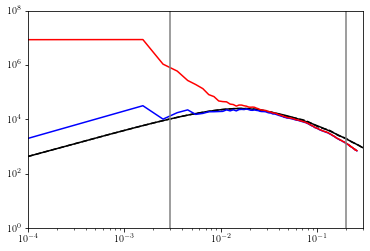

In [34]:
plt.plot(kpk1[:,0], kpk1[:,1], 'k-',
         kpk2[:,0], kpk2[:,1], 'k--',
         kpk3[:,0], kpk3[:,1], 'b-',
         kpk4[:,0], kpk4[:,1], 'r-')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(xmax=0.)
plt.xscale('log')
plt.axis([0.0001, 0.3, 1, 1.e8])
plt.axvline(0.003, color='grey')
plt.axvline(0.2, color='grey')

In [35]:
((kpk1[:,0]>0.003)&(kpk1[:,0]<0.2)).sum()

420

In [36]:
args  = Args(0.003,  2.e-1, '111111101', '/Users/mehdi/Downloads/pk_v0_26_red_0_0.5.txt')
args1 = Args(0.003,  2.e-1, '111111101', '/Users/mehdi/Downloads/pk_v0_26_red_1_0.5.txt')

In [37]:
args, args1

({'kmin': 0.003, 'kmax': 0.2, 'params_str': '111111101', 'pkobs': '/Users/mehdi/Downloads/pk_v0_26_red_0_0.5.txt'},
 {'kmin': 0.003, 'kmax': 0.2, 'params_str': '111111101', 'pkobs': '/Users/mehdi/Downloads/pk_v0_26_red_1_0.5.txt'})

In [38]:
samples   = fit_BAO(args)
samples1  = fit_BAO(args1)

Arguments for the fitting:  {'kmin': 0.003, 'kmax': 0.2, 'params_str': '111111101', 'pkobs': '/Users/mehdi/Downloads/pk_v0_26_red_0_0.5.txt'}
[ 1.     1.    10.     1.     1.     1.     1.     7.784] ['alpha', 'a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'sigmanl2'] 8
fixed params:  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Parameters from Powell optimization:  [ 1.05975227e+00  7.44611689e+02 -1.51800007e+03  2.56492762e+01
  4.40678896e+04 -1.37032076e+05  2.42973980e+00  1.06488538e+02]
Initial parameters for MCMC:  [ 1.     1.    10.     1.     1.     1.     1.     7.784]


/Users/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: overflow encountered in multiply
/Users/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


<class 'list'>
Running MCMC...
chain length = 800  minlength = 800
scalereduction =  [1.00897191 1.00110057 1.00098611 1.00347082 1.00596155 1.00065269
 1.00170435 1.000558  ]
Done.
Mean acceptance fraction for chain  0 :  0.32940625
Mean acceptance fraction for chain  1 :  0.32940625
Mean acceptance fraction for chain  2 :  0.32156250000000003
Mean acceptance fraction for chain  3 :  0.31821875
Mean acceptance fraction for chain  4 :  0.32681250000000006
Mean acceptance fraction for chain  5 :  0.328125
Mean acceptance fraction for chain  6 :  0.32484375
Mean acceptance fraction for chain  7 :  0.32425
Mean acceptance fraction for chain  8 :  0.32925000000000004
Mean acceptance fraction for chain  9 :  0.32315625
length of merged chain =  160000
MCMC result: 
alpha=0.9799983082615501+0.14003479620951975-0.12238478683036969
a1=314.83267679926394+15186.96120834417-15379.791821244784
a2=-467.4923351095426+3201.957856001748-3213.6139437999177
a3=16.036251982482348+63.881020986545856-69.94

In [39]:
np.save('samples.npy', samples)
np.save('samples1.npy', samples1)

In [12]:
from chainconsumer import ChainConsumer

In [40]:
samples  = np.array(samples)
samples1 = np.array(samples1)

In [59]:
c = ChainConsumer()
parameters = [r"$\alpha$", "a1", "a2", "a3", "a4", "a5", "b", r"$\Sigma^{2}_{NL}$"] #r"$\Sigma^{2}_{s}$"
c.add_chain(samples,  parameters=parameters, name='Before sub-sampling', color='k')
c.add_chain(samples1, parameters=parameters, name='After sub-sampling', color='r')

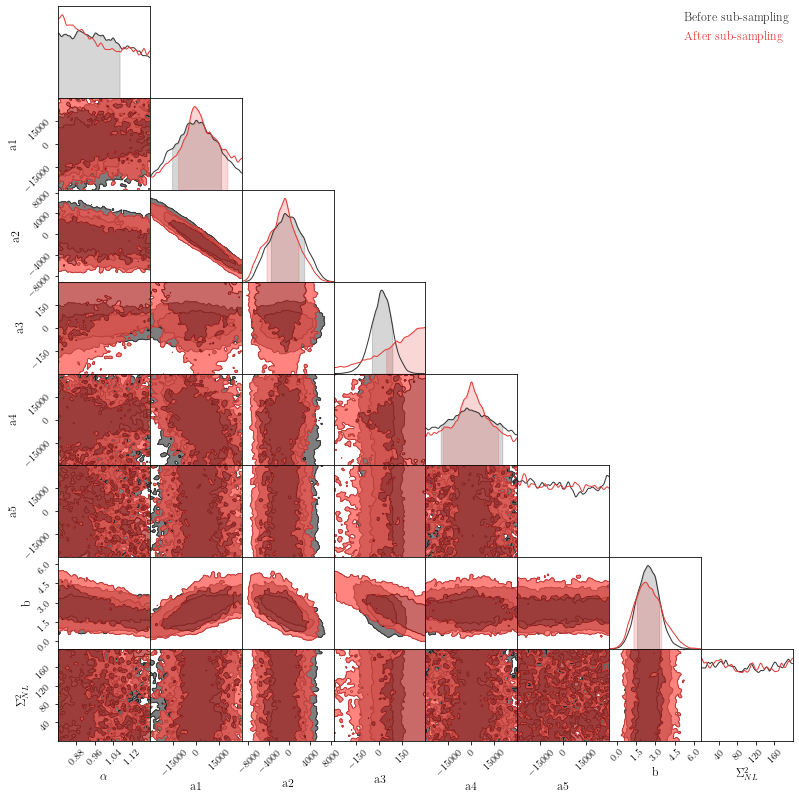

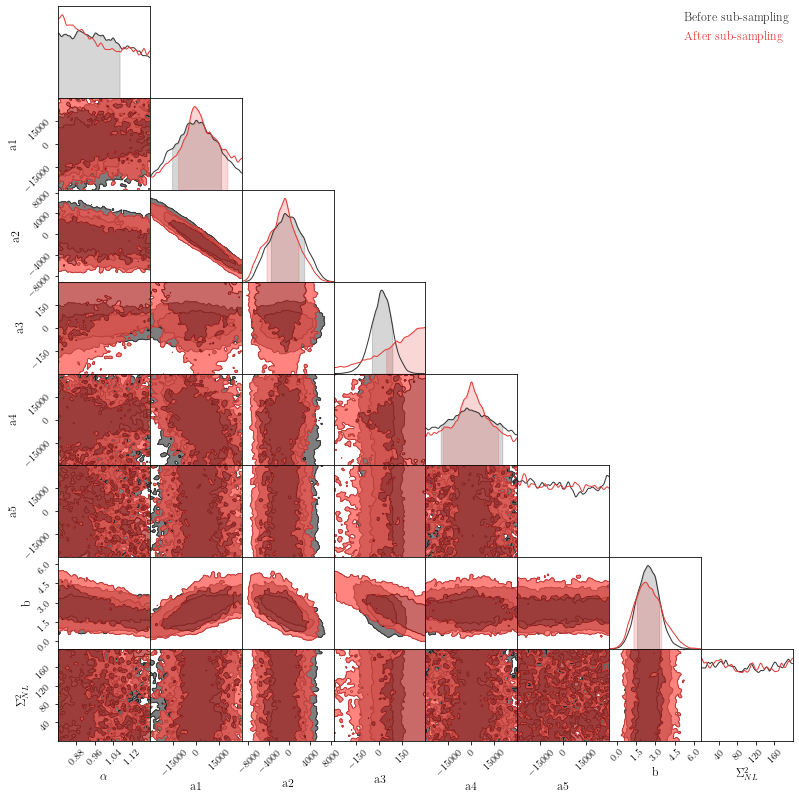

In [64]:
c.plotter.plot()

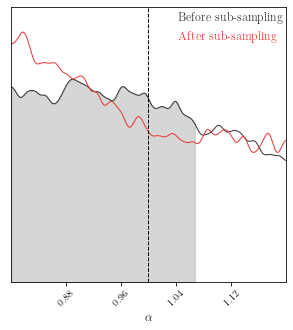

In [63]:
fig = c.plotter.plot(parameters=[r'$\alpha$'], figsize=3., truth=[1.])


In [43]:
import corner

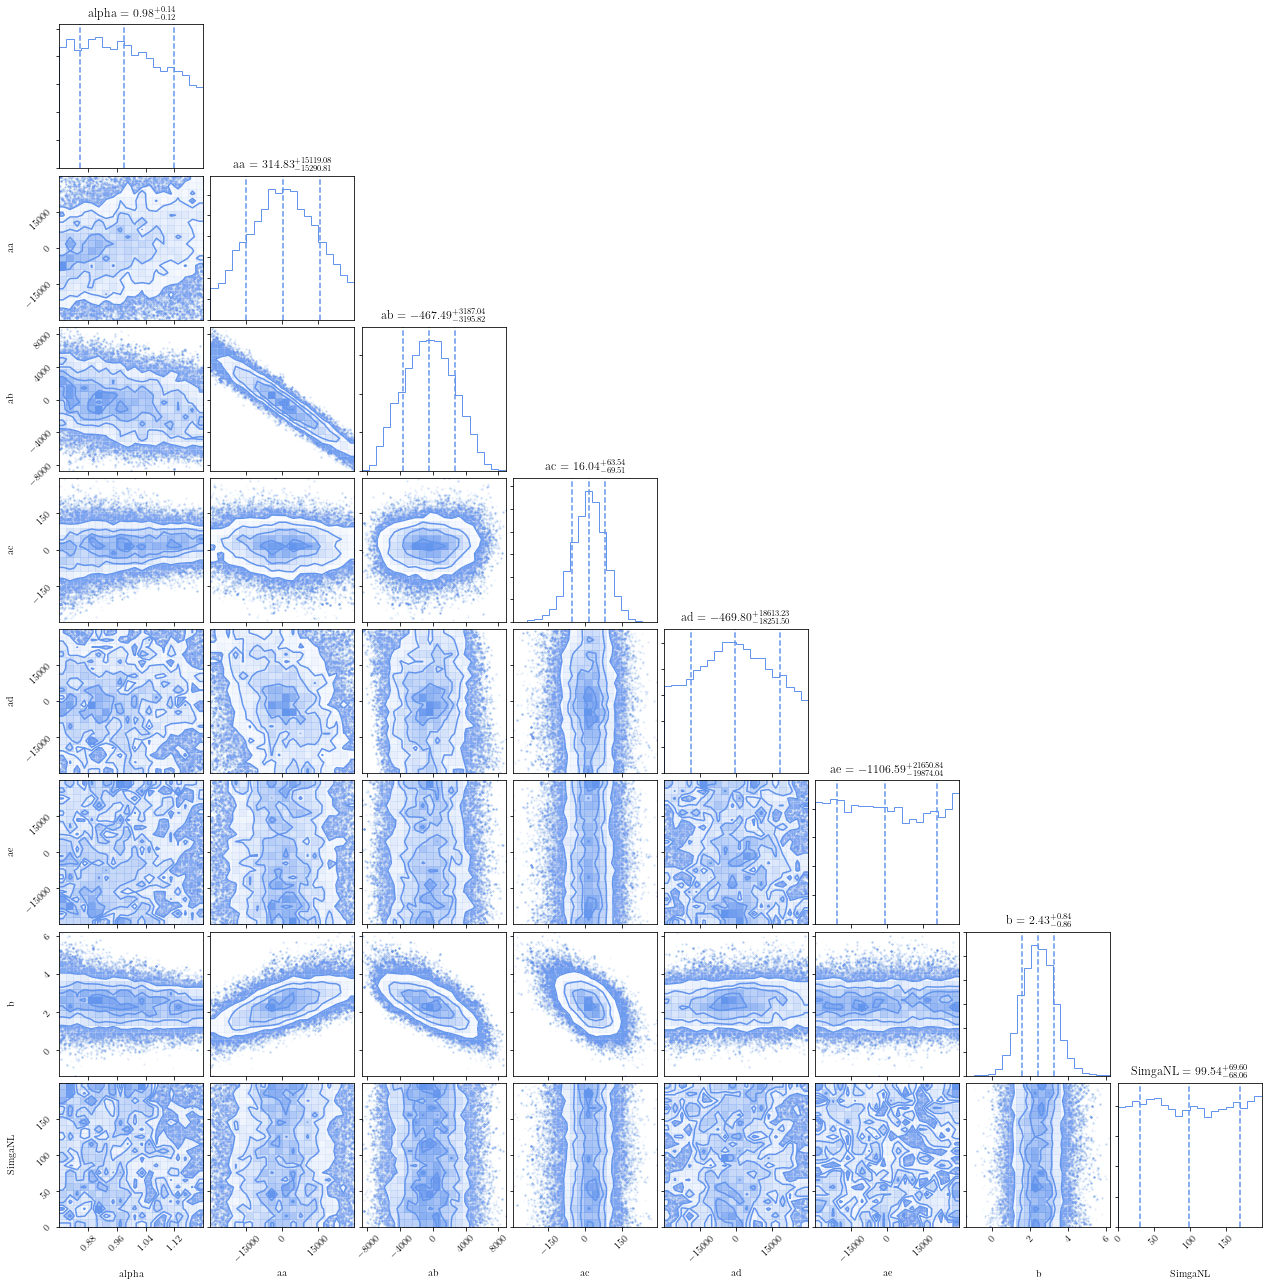

In [45]:
fig = corner.corner(samples, labels=parameters,
                    quantiles=[.1586555, .50, .8413445], 
                    show_titles=True, color='cornflowerblue') #    truths=[.1, 0.1, 0.2], 

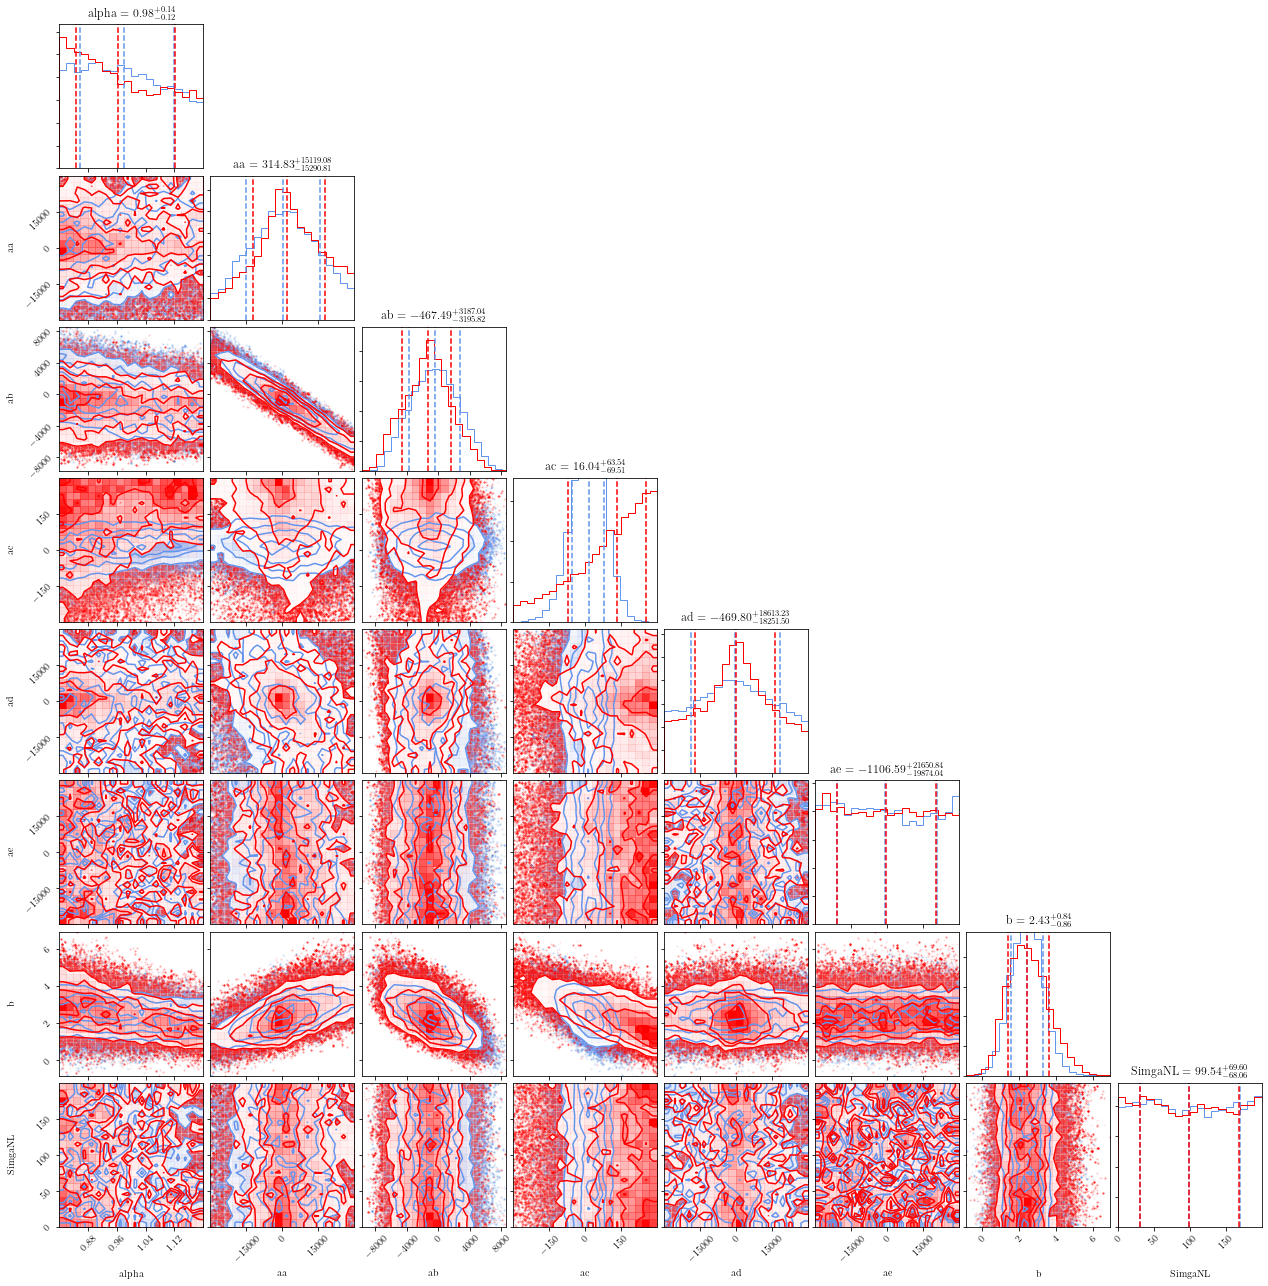

In [46]:
corner.corner(samples1, labels=parameters,
              quantiles=[.1586555, .50, .8413445], show_titles=False, color='red',
              fig=fig) #    truths=[.1, 0.1, 0.2], 